In [1]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda as cuda
from dataclasses import dataclass

In [ ]:
"""
gpt2:        n_layer=12, n_head=12, n_embed=768    #  124M params
gpt2-medium: n_layer=24, n_head=16, n_embed=1024   #  350M params
gpt2-large:  n_layer=36, n_head=20, n_embed=1280   #  774M params
gpt2-xl:     n_layer=48, n_head=25, n_embed=1600   # 1558M params
"""

# OpenAI GPT series

In [2]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config) -> None:
        super(CausalSelfAttention, self).__init__()
        assert config.n_embed % config.n_head == 0
        self.n_head = config.n_head
        self.n_embed= config.n_embed

        self.c_attn= nn.Linear(config.n_embed, 3 * config.n_embed)
        self.c_proj= nn.Linear(config.n_embed, config.n_embed)

        self.register_buffer('bias',
            torch.tril(torch.ones(config.block_size, config.block_size))
            .view(1, 1, config.block_size, config.block_size)
        )

    def forward(self, x):
        B, T, C= x.size()
        qkv= self.c_attn(x)
        q, k, v= qkv.split(self.n_embed, dim=2)
        k= k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q= q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v= v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        att= (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att= att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att= F.softmax(att, dim=-1)

        y= att @ v
        y= y.transpose(1, 2).contiguous().view(B, T, C)
        y= self.c_proj(y)

        return y


class MLP(nn.Module):
    def __init__(self, config) -> None:
        super(MLP, self).__init__()
        self.c_fc=   nn.Linear(config.n_embed, 4 * config.n_embed)
        self.gelu=   nn.GELU(approximate='tanh')
        self.c_proj= nn.Linear(4 * config.n_embed, config.n_embed)

    def forward(self, x):
        x= self.c_fc(x)
        x= self.gelu(x)
        x= self.c_proj(x)

        return x


class DecoderBlock(nn.Module):
    def __init__(self, config) -> None:
        super(DecoderBlock, self).__init__()
        self.ln_1= nn.LayerNorm(config.n_embed)
        self.attn= CausalSelfAttention(config)
        self.ln_2= nn.LayerNorm(config.n_embed)
        self.mlp = MLP(config)

    def forward(self, x):
        x= x + self.attn(self.ln_1(x))
        x= x + self.mlp(self.ln_2(x))

        return x


class GPT2(nn.Module):
    def __init__(self, config) -> None:
        super(GPT2, self).__init__()
        self.config= config
        self.transformer= nn.ModuleDict(dict(
            wte= nn.Embedding(config.vocab_size, config.n_embed),
            wpe= nn.Embedding(config.block_size, config.n_embed),
            h= nn.ModuleList([DecoderBlock(config) for _ in range(config.n_layer)]),
            ln_f= nn.LayerNorm(config.n_embed)
        ))
        self.lm_head= nn.Linear(config.n_embed, config.vocab_size, bias=False)
        self.transformer.wte.weight= self.lm_head.weight

    def forward(self, idx, targets=None):
        B, T= idx.size()
        assert T <= self.config.block_size, f'Block size is only {self.config.block_size}'
        pos= torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb= self.transformer.wpe(pos)
        tok_emb= self.transformer.wte(idx)
        x= tok_emb + pos_emb

        for block in self.transformer.h:
            x= block(x)

        x= self.transformer.ln_f(x)
        logits= self.lm_head(x)

        loss= None
        if targets is not None:
            loss= F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss


In [3]:
@dataclass
class GPTConfig:
    block_size:int= 1024  # max sequence length
    vocab_size:int= 50257 # number of tokens
    n_layer:int= 12       # number of layers
    n_head:int= 12        # number of heads
    n_embed:int= 768      # embedding dimension


model= GPT2(GPTConfig())
model

GPT2(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x DecoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

Number of parameters: 124439808


In [ ]:
B, T= 4, 8 # batch_size, seq_len

tokens= torch.randint(0, GPTConfig.vocab_size, (B*T + 1,))

x= tokens[:-1].view(B, T)
y= tokens[1:].view(B, T)

print('input tensor')
print(x)
print('\nlabels')
print(y)

input tensor
tensor([[33747, 40506,  1444, 42488,  4743,  6646, 34375, 32471],
        [42000,  7094, 48406, 13895, 14562, 17729, 49490, 46442],
        [38413, 48992, 16797,  4454, 19198, 18992, 30842, 41780],
        [17527, 28296, 35172, 24626, 14183, 34746, 29481,  5006]])

labels
tensor([[40506,  1444, 42488,  4743,  6646, 34375, 32471, 42000],
        [ 7094, 48406, 13895, 14562, 17729, 49490, 46442, 38413],
        [48992, 16797,  4454, 19198, 18992, 30842, 41780, 17527],
        [28296, 35172, 24626, 14183, 34746, 29481,  5006,  8352]])


In [ ]:
# expected loss -- random init model
model.eval()
_, loss= model(x, y)

print(loss)

tensor(10.8264, grad_fn=<NllLossBackward0>)


# GPT-2 XL: 1.5B params -- Memory test

In [5]:
@dataclass  # gpt2-xl: 1558M params
class GPTConfig:
    block_size:int= 1024  # max sequence length
    vocab_size:int= 50257 # number of tokens
    n_layer:int= 48       # number of layers
    n_head:int= 25        # number of heads
    n_embed:int= 1600     # embedding dimension


model= GPT2(GPTConfig()).to('cuda')

total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

Number of parameters: 1557611200


In [6]:
B, T= 8, 512 # batch_size, seq_len

tokens= torch.randint(0, GPTConfig.vocab_size, (B*T + 1,))

x= tokens[:-1].view(B, T).to('cuda')
y= tokens[1:].view(B, T).to('cuda')

In [7]:
cuda.reset_peak_memory_stats()
# Run the model
model.eval()
logits, loss= model(x, y)
# Measure peak memory usage
peak_memory= cuda.max_memory_allocated()

del logits, loss
cuda.empty_cache()

print(f"Forward Pass Memory: {np.round(peak_memory / 10**6, decimals=2)} MB")

Forward Pass Memory: 38625.36 MB


# GPT-2 -- Simplified training and text generation

In [8]:
class SimpleTokenizer:
    def __init__(self, text) -> None:
        chars= sorted(list(set(text)))
        self.vocab_size= len(chars)
        self.stoi= {ch:i for i, ch in enumerate(chars)}
        self.itos= {i:ch for i, ch in enumerate(chars)}

    def encode(self, text):
        return [self.stoi[c] for c in text]

    def decode(self, tokens):
        return ''.join([self.itos[t] for t in tokens])


In [9]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

with open('input.txt', 'r', encoding='utf-8') as f:
    text= f.read()

tok= SimpleTokenizer(text)

print(f'Training text length: {len(text)}')
print(f'Vocab size: {tok.vocab_size}')

--2025-01-04 09:15:46--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2025-01-04 09:15:46 (54.9 MB/s) - ‘input.txt’ saved [1115394/1115394]

Training text length: 1115394
Vocab size: 65


In [10]:
@dataclass
class GPTConfig:
    block_size:int= 1024  # max sequence length
    vocab_size:int= tok.vocab_size # number of tokens
    n_layer:int= 12       # number of layers
    n_head:int= 12        # number of heads
    n_embed:int= 768      # embedding dimension

model= GPT2(GPTConfig()).to('cuda')

total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {total_params}')

Number of parameters: 85892352


In [11]:
def generate(model, idx, max_new_tokens): # top-k sampling approach (HF default)
    model.eval()
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):
        with torch.no_grad():
            logits, _= model(idx)    # (B, T, vocab_size)
            logits= logits[:, -1, :] # (B, vocab_size)
            probs= F.softmax(logits, dim=-1) # (B, C)
            topk_probs, topk_indices= torch.topk(probs, 50, dim=-1)
            ix= torch.multinomial(topk_probs, num_samples=1) # (B, 1)
            xcol= torch.gather(topk_indices, -1, ix) # (B, 1)
            idx= torch.cat((idx, xcol), dim=1) # (B, T+1)

    return idx


In [12]:
context= torch.zeros((1, 1), dtype=torch.long, device='cuda')
print(tok.decode(generate(model, context, max_new_tokens=500)[0].tolist()))


:jHkCCwEtsD
muqLsMidgHkHrocKMe$FnX!JCRO;u?AF;xPJ$qo&TnWXif oGCq$UoQKPZgGO
IIu S,HY'T&Qtc,rbSSL
3$Zi3NNV,OF,duz:LtJLI&HbVKGFCZuuN$nuW?QI'IoXXxvhq&
Nn nqvvWsxxEqv'dk3WUP.koSZ?sqH
RQZudcpE.aPIIyQNy.QYsUmBKE-.yVXS-UFFtjJWqoEbZ;uHY i
paPGCAcOfzOA&j;y&xa3as'cxKu3NghdMlytNZFZSXKwd$JsS-fIPt,?,dv$L
BRENNNRc'-JYHFVVTShde r R.Tkcwpn$.DTFKCAtAAohIul:3fCLjhi!vAuArpoTE
e!y-w;IAJmKx&pafBhWQuj:slnqnOQMNtMZwGacL oK;bpNTiu;BijxT?.bSaih:zsux$.,oqb-
a!WxG$WtA&nfNn'!JKyrjHWjJW !bDyyxc
h:RZttFdcEerU?TF-$f'?c$$xkb'J-k


In [13]:
torch.manual_seed(1337)

def get_batch(data, batch_size, block_size):
    # generate a small batch of data of inputs x and target y
    ix= torch.randint(len(data) - block_size, (batch_size,))
    x= torch.stack([data[i:i+block_size] for i in ix])
    y= torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y= x.to('cuda'), y.to('cuda')

    return x, y


In [14]:
from tqdm import tqdm

def lets_train_it(model, data, batch_size, block_size, optimizer, max_steps):
    losses= torch.zeros(max_steps)

    # training loop
    for step in tqdm(range(max_steps)):
        # sample a batch of data
        xb, yb= get_batch(data, batch_size, block_size)

        # evaluate the loss
        _, loss= model(xb, yb)
        losses[step]= loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses


In [15]:
data= torch.tensor(tok.encode(text))
optimizer= torch.optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), eps=1e-8)

batch_size= 8
block_size= 512

losses= lets_train_it(model, data, batch_size, block_size, optimizer, max_steps=2500)

100%|██████████| 2500/2500 [07:28<00:00,  5.58it/s]


In [16]:
xb, yb= get_batch(data, 8, 512)

cuda.reset_peak_memory_stats()
# Run the model
model.eval()
logits, loss= model(xb, yb)
# Measure peak memory usage
peak_memory= cuda.max_memory_allocated()

del logits, loss
cuda.empty_cache()

print(f"Forward Pass Memory: {np.round(peak_memory / 10**6, decimals=2)} MB")

Forward Pass Memory: 5127.45 MB


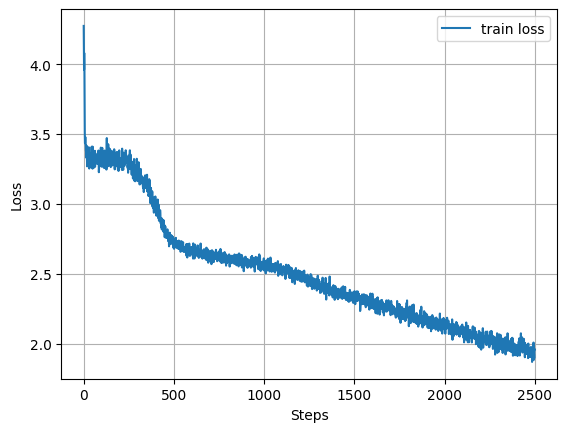

In [17]:
import matplotlib.pyplot as plt

plt.plot(losses, label='train loss')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [18]:
context= torch.zeros((1, 1), dtype=torch.long, device='cuda')
print(tok.decode(generate(model, context, max_new_tokens=500)[0].tolist()))


URLMI:
To shanc not him.

PARTIO:
That farmiu, herrk'pely comeace of his tentleve.
It:
Pook, if ky ling? You bosth; heavirs scoon'
I God portine, likd: by thus in the gure.
Wo my, un loo akel being a I reerven a heage!
The carlight yer a ware mayst of my brakd
Fod an dosendy which horch aswide proower,

FUERKE:
Abll, fo his neart ind me thy wild well non's kine
Then a me har berame ust fo but toind.

KING RINGREWARDARD:
This!

PETRTORDYO:
Yo Yay thost guse to tilkue his hers uno herts thale,--
t
